# Test path integrator RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

import motion, path_rnn

## Define dataset and RNN model

In [2]:
""" class MotionDataset(Dataset):

    def __init__(self, fpath):

        # Load data from .npz file
        with np.load(fpath) as data:
            self.vel = torch.Tensor(data['vel'])
            self.pos = torch.Tensor(data['pos'])
            self.num_trials = data['vel'].shape[0]

    def __getitem__(self, index):
        return self.vel[index], self.pos[index]
 
    def __len__(self):
        return self.num_trials """

" class MotionDataset(Dataset):\n\n    def __init__(self, fpath):\n\n        # Load data from .npz file\n        with np.load(fpath) as data:\n            self.vel = torch.Tensor(data['vel'])\n            self.pos = torch.Tensor(data['pos'])\n            self.num_trials = data['vel'].shape[0]\n\n    def __getitem__(self, index):\n        return self.vel[index], self.pos[index]\n \n    def __len__(self):\n        return self.num_trials "

In [3]:
""" class PathRNN(torch.nn.Module):
    
    def __init__(self, n_units):

        super(PathRNN, self).__init__()

        self.n_units = n_units

        # RNN Layer
        self.rnn = torch.nn.RNN(input_size=2, hidden_size=n_units, num_layers=1, nonlinearity='tanh', batch_first=True)

        # Output layer
        self.output = torch.nn.Linear(n_units, 2)
    
    def forward(self, vel):
        
        # Run RNN on velocity sequences to get hidden unit values
        u_vals, _ = self.rnn(vel)
        
        # Apply output weights to get estimated position
        pos_est = self.output(u_vals)
        
        return pos_est, u_vals """

" class PathRNN(torch.nn.Module):\n    \n    def __init__(self, n_units):\n\n        super(PathRNN, self).__init__()\n\n        self.n_units = n_units\n\n        # RNN Layer\n        self.rnn = torch.nn.RNN(input_size=2, hidden_size=n_units, num_layers=1, nonlinearity='tanh', batch_first=True)\n\n        # Output layer\n        self.output = torch.nn.Linear(n_units, 2)\n    \n    def forward(self, vel):\n        \n        # Run RNN on velocity sequences to get hidden unit values\n        u_vals, _ = self.rnn(vel)\n        \n        # Apply output weights to get estimated position\n        pos_est = self.output(u_vals)\n        \n        return pos_est, u_vals "

## Generate simulated trajectories

In [4]:
sim = motion.MotionSimulation(500, 500, std_norm=0.2, time_step=0.01)
sim.run()

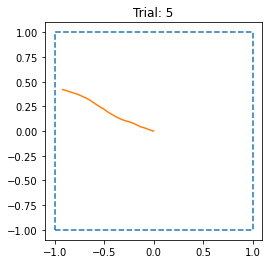

In [5]:
trial_plt = 5

fig, ax = plt.subplots(1, 1)
sim.plot_position(5)
ax.set_title(f'Trial: {trial_plt}');

## Train RNN on trajectory data

### Load data from simulation into PyTorch

In [6]:
# Convert data to PyTorch Dataset (stores NumPy arrays as Tensors)
dset = sim.to_dataset()

# Use DataLoader class to handle batching
train_dataloader = DataLoader(dset, batch_size=100, shuffle=True)

### Train RNN model

In [12]:
# Instantiate model
model = path_rnn.PathRNN(n_units=32)

# Define hyperparameters
n_epochs = 20
lr=0.001

# Define Loss, Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
# Training Run
for epoch in range(1, n_epochs + 1):

    for vel_batch, pos_batch in train_dataloader:

        # Clear gradients from previous epoch
        optimizer.zero_grad()

        # Compute loss
        pos_est, u_vals = model(vel_batch)
        loss = criterion(pos_est, pos_batch)

        # Compute gradient via backprop
        loss.backward()

        # Update model parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/20............. Loss: 0.1178
Epoch: 20/20............. Loss: 0.0665


## Compare predicted motion to ground truth

In [15]:
pos_est = model(dset.vel)
pos_est_plt = pos_est[0].detach().numpy()

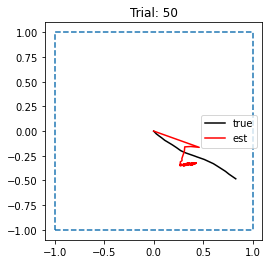

In [11]:
trial_plt = 50

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_title(f'Trial: {trial_plt}')

motion.plot_position_estimate(sim.boundary, sim.pos[trial_plt], pos_est_plt[trial_plt], ax)